# ID- AI-19

INTRODUCTION

I have to predict plant species.

In [1]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
#!pip install  

I made a list of all species of plant

In [3]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

Assign directorty path of file

In [4]:
#file path
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = 'C:\\Users\\Dr. farid\\Desktop\\shihab Litu\\kaggle Assignment\\plant'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
#sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [5]:

#catagory
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


I load all the plant image from 12 folder and make a list which name is train. 
After that I make a dataframe which
include file, category id, category.

In [6]:
#train file read
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

(4750, 3)

In [7]:
train.head(2)

,file,category_id,category
0,train/Black-grass/0050f38b3.png,0,Black-grass
1,train/Black-grass/0183fdf68.png,0,Black-grass


In [8]:
#train list creation
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape

(2400, 3)

I made a list which include all the test data like training data before.

In [9]:
#test list creation
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

(794, 2)

Now, I load all the image of training data by making a function of red_img.

In [10]:
#read file
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

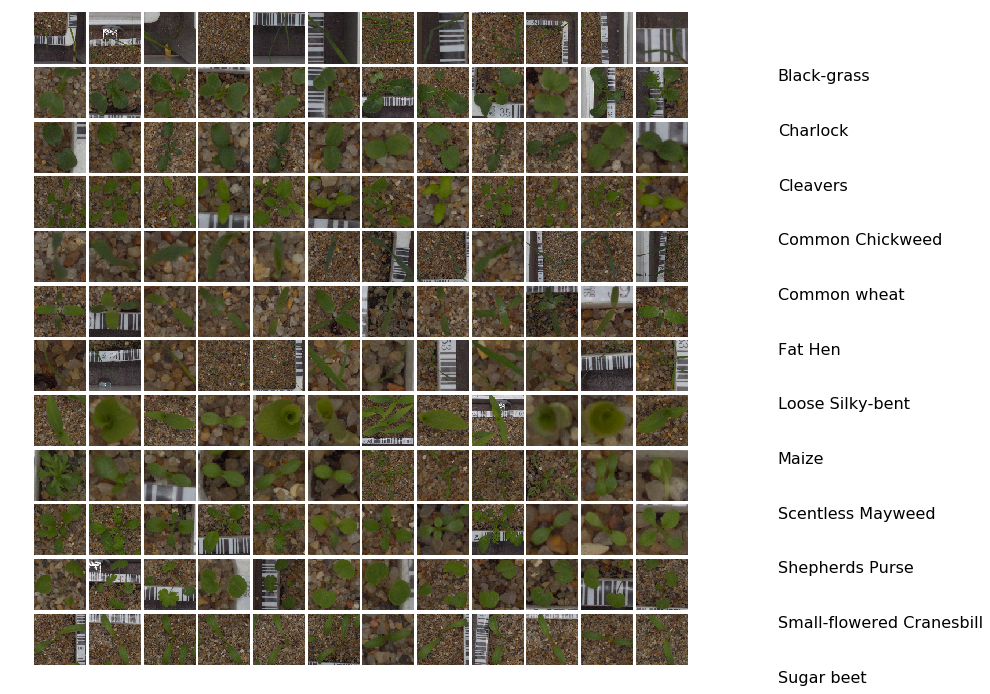

In [11]:
#image show
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (90, 90))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [12]:

#test train split
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

I use xception pretrained model.Besides, I use small image size(90*90) to run quickly and I use average pooling.
If I get enough time I will try for max pooling later for better accuracy. After that I covert x_train image into numpy array.
Then I input image into xception model.

In [13]:
#xception model load 
INPUT_SIZE = 90
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [01:36, 24.83it/s]


Train Images shape: (2400, 90, 90, 3) size: 58,320,000


Now, I load the xception model. I used bottleneck for full training. Then we load the wight.

In [14]:
#exception model load

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)



((1899, 90, 90, 3), (501, 90, 90, 3), (1899,), (501,))


In [15]:
#training
train_x_bf = xception_bottleneck.predict(Xtr, batch_size = 64, verbose=1)


1899/1899 [==============================] - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 54s - ETA: 46 - ETA: 38 - ETA: 30 - ETA: 21 - ETA: 13 - ETA: 5 - 242s 128ms/step


#validation 
valid_x_bf = xception_bottleneck.predict(Xv, batch_size = 64, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

I feel that if I use logistic regression model after training then there is possibility to get better output.

In [ ]:
#loficstic regression layer for better accuracy
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

In [ ]:
#printing validation accuracy
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

In [ ]:
#confusion matrix initialization
cnf_matrix = confusion_matrix(yv, valid_preds)


I just use short form of category name and made a dataframe.

In [ ]:
#catagory abbreviation creation
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

In [ ]:
#confusion matrix
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

Input the test data into model to predict the image species.Then we make a submission file to get kaggle accuracy.

In [ ]:
#testing data set prediction
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

In [ ]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

In [ ]:
#ouput file write
test['category_id'] = test_preds
test['species'] = [CATEGORIES[c] for c in test_preds]
test[['file', 'species']].to_csv('submissionvgg16.csv', index=False)

CONCLUSION



I get kaggle accuracy is 0.9424 .To run this model GPU pc is necessary. If I have I would try different model and different 
way to find the better accuracy. I also feel that if I detect green color of image. it will give me more accuracy.

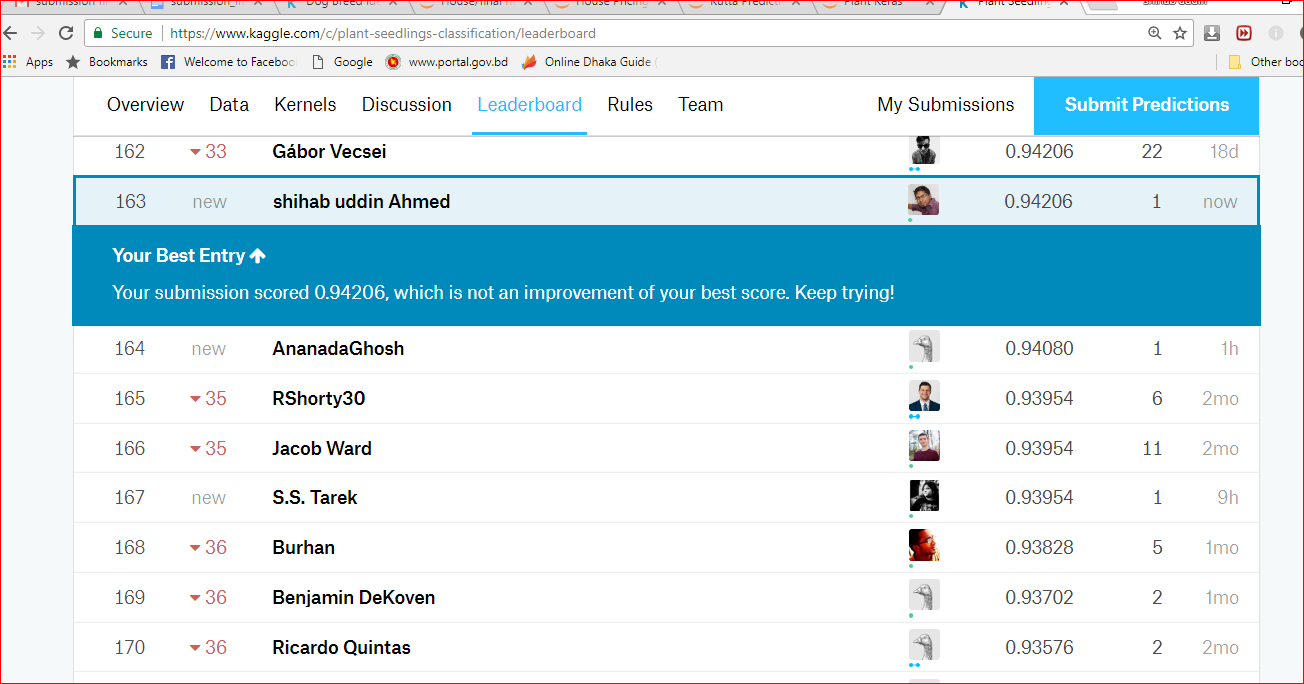

In [2]:
from IPython.display import Image
Image('kaggle.PNG')